# Map visualization with Geopandas

Geo data taken from https://www.suche-postleitzahl.org/downloads and http://insideairbnb.com/get-the-data.html.

For reference see https://juanitorduz.github.io/germany_plots/

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from geopandas import GeoDataFrame
from shapely.geometry import Point

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 11]
plt.style.use('fivethirtyeight')

## Geo Data of Germany and Berlin

In [2]:
plz_shape_df = gpd.read_file('geo_data/plz-gebiete.shp', dtype={'plz': str})

In [3]:
plz_shape_df

,plz,note,geometry
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ..."
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ..."
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ..."
3,52074,52074 Aachen,"POLYGON ((5.97486 50.79804, 5.97495 50.79809, ..."
4,52531,52531 Ãbach-Palenberg,"POLYGON ((6.01507 50.94788, 6.03854 50.93561, ..."
...,...,...,...
8720,02899,"02899 Ostritz, SchÃ¶nau-Berzdorf","POLYGON ((14.85296 51.06854, 14.85449 51.06859..."
8721,02929,02929 Rothenburg/O.L.,"POLYGON ((14.85491 51.32895, 14.85608 51.33004..."
8722,02827,02827 GÃ¶rlitz,"POLYGON ((14.91168 51.14243, 14.91571 51.14571..."
8723,02828,02828 GÃ¶rlitz,"POLYGON ((14.93413 51.16084, 14.93451 51.16123..."


In [4]:
plz_region_df = pd.read_csv(
    'geo_data/zuordnung_plz_ort.csv', 
    sep=',', 
    dtype={'plz': str}
)

plz_region_df.drop('osm_id', axis=1, inplace=True)

germany_df = pd.merge(
    left=plz_shape_df, 
    right=plz_region_df, 
    on='plz',
    how='inner'
)
germany_df.drop(['note'], axis=1, inplace=True)

In [5]:
berlin_neighbourhoods_df = gpd.read_file('geo_data/neighbourhoods.geojson')

berlin_neighbourhoods_df = berlin_neighbourhoods_df \
    [~ berlin_neighbourhoods_df['neighbourhood_group'].isnull()]

In [6]:
berlin_neighbourhoods_df

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52..."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52..."
...,...,...,...
135,Hellersdorf-Ost,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.62135 52.52704, 13.62079 52..."
136,Mahlsdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.65554 52.52982, 13.65693 52..."
137,Ost 1,Reinickendorf,"MULTIPOLYGON (((13.36666 52.55823, 13.36561 52..."
138,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52..."


## Geo data of bike stations

In [7]:
berlin_df = germany_df.query('ort == "Berlin"')

In [8]:
eco_bike_data = pd.read_excel('ADFC/fetched_eco_bike_data.xlsx')
eco_bike_data = eco_bike_data[eco_bike_data['city'] == "Berlin"]
eco_bike_data.drop(['city', 'id_list', 'Distance to center [km]', 'fetched_url'], axis=1, inplace=True)
eco_bike_data['number'] = eco_bike_data['number'].astype(int)
eco_bike_data.set_index('number', inplace=True)

In [9]:
eco_bike_data['location'] = list(zip(eco_bike_data['longitude'], eco_bike_data['latitude']))

In [10]:
bike_stations = eco_bike_data.to_dict()['location']

[Text(0.5, 1.0, 'Berlin - Bike Stations'), None]

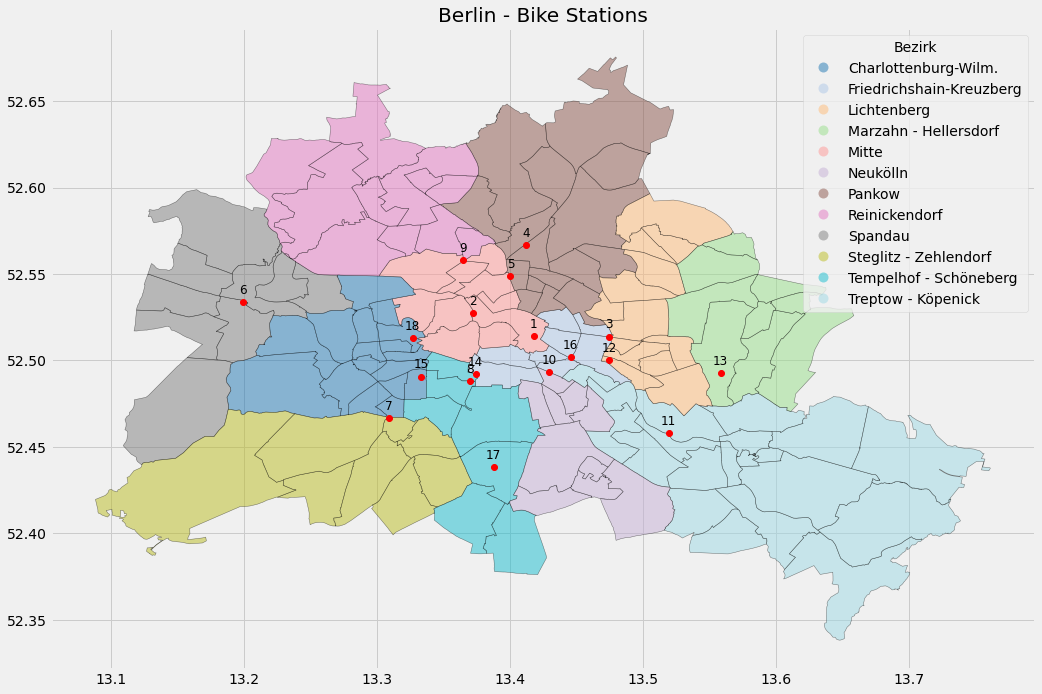

In [11]:
fig, ax = plt.subplots()

berlin_neighbourhoods_df.plot(
    ax=ax, 
    column='neighbourhood_group',
    categorical=True, 
    legend=True, 
    legend_kwds={'title': 'Bezirk', 'loc': 'upper right'},
    cmap='tab20', 
    edgecolor='black',
    alpha=0.5
)

for c in bike_stations.keys():

    ax.text(
        x=bike_stations[c][0], 
        y=bike_stations[c][1] + 0.005, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        bike_stations[c][0], 
        bike_stations[c][1], 
        marker='o',
        c='red'
    )

ax.set(
    title='Berlin - Bike Stations', 
    aspect=1.3
)

In [12]:
#geometry = gpd.points_from_xy(eco_bike_data['longitude'], eco_bike_data['latitude'], crs="EPSG:4326")
#eco_bike_data['geometry'] = geometry
geometry = [Point(xy) for xy in zip(eco_bike_data['longitude'], eco_bike_data['latitude'])]

In [13]:
bike_stations_geo_data = eco_bike_data.copy()
bike_stations_geo_data.drop(['latitude', 'longitude', 'location'], axis=1, inplace=True)
gdf = GeoDataFrame(bike_stations_geo_data, crs="EPSG:4326", geometry=geometry)
gdf['name'] = gdf.index

In [14]:
m = berlin_neighbourhoods_df.explore(
     column="neighbourhood_group",  # make choropleth based on "BoroName" column
     scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
     legend=True, # show legend
     k=10, # use 10 bins
     legend_kwds=dict(colorbar=False), # do not use colorbar
     name="berlin" # name of the layer in the map
)

"""
m = berlin_df.explore(
     scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
     legend=True, # show legend
     k=10, # use 10 bins
     legend_kwds=dict(colorbar=False), # do not use colorbar
     name="berlin" # name of the layer in the map
)
"""

gdf.explore(
     m=m, # pass the map object
     color="red", # use red color on all points
     marker_kwds=dict(radius=10, fill=True), # make marker radius 10px with fill
     tooltip="name", # show "name" column in the tooltip
     tooltip_kwds=dict(labels=False), # do not show column label in the tooltip
     name="bike_stations" # name of the layer in the map
)

folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map